In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


# Load Data

In [2]:
# import raw data
df_raw = pd.read_csv('./data/bj_lmq_train.csv', usecols=['lat','lng','time','dm'])
print('Area:', int(df_raw['lat'].unique().shape[0]) * int(df_raw['lng'].unique().shape[0]), 'blocks')
print('Period:', int(df_raw['time'].unique().shape[0]/24), 'days')

Area: 1380 blocks
Period: 28 days


In [3]:
data_wide = df_raw.pivot_table(index=['lat','lng'], columns='time', values=['dm'], fill_value=0).reset_index()
data_wide.shape

(1380, 674)

In [4]:
# fixed image size
IMG_HEIGHT = df_raw['lat'].unique().shape[0]
IMG_WIDTH = df_raw['lng'].unique().shape[0]

# timestep to lookback
depth = 5
# number of timesteps
n_Ts = data_wide.shape[1]-2           

In [5]:
# extract dm images for each timestep
imgs = np.array([np.reshape(data_wide.iloc[:,2+i].values, (IMG_HEIGHT,IMG_WIDTH)).astype(np.float32) for i in range(n_Ts)])

In [6]:
# 3D image cubes as input 
x_input = np.empty([n_Ts-depth,depth,IMG_HEIGHT,IMG_WIDTH], dtype=np.float32)
for i in range(n_Ts-depth):
    x_input[i] = imgs[i:i+depth]

# 2D image at next timestep as target
y_target = imgs[depth:, :, :]
y_target = y_target.reshape(y_target.shape[0],y_target.shape[1] * y_target.shape[2])

# Define The 3D-CNN Model Structure

In [7]:
# params
num_channels = 1
conv1_features = 64
conv2_features = 2

max_pool_strides = {'l1': [1,1], 'l2':[1,1]} 
fc_layer_size = [256,128]

batch_size = 32
epoches = 1000
eval_every = 50
pred_every = 100

In [8]:
def weight_var(name, shape, stddev=0.1, mean= 0.0):
    wt = tf.get_variable(name=name, shape=shape, dtype=tf.float32,
                         initializer=tf.truncated_normal_initializer(mean=mean, stddev=stddev))
    return wt

def bias_var(name, shape, const=0.01):
    bias = tf.get_variable(name=name, shape=shape, dtype=tf.float32, initializer=tf.constant_initializer(const))
    return bias

def conv3d(input_data, wt):
    # d h w
    conv = tf.nn.conv3d(input_data, wt, strides=[1, 1, 1, 1, 1], padding='SAME')
    return conv
    
def max_pool3d(input_data, d=2, h=2, w=2):
    max_pool = tf.nn.max_pool3d(input_data, ksize=[1, d, h, w, 1],
                               strides=[1, 1, 1, 1, 1], padding='SAME')
    return max_pool


In [9]:
# define the structure of neural network 

def conv_net(x_input):

    # Convoluational Layer 1
    with tf.variable_scope('conv1'):
        # convolutional layer 1 variables, kernel size 2*2*2
        conv1_weight = weight_var('conv1_weight', [2, 2, 2, num_channels, conv1_features], 0.1)
        conv1_bias = bias_var('conv1_bias', [conv1_features], 0.05)
        
        conv1 = conv3d(x_input, conv1_weight)
        relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
        max_pool1 = max_pool3d(relu1)
    
    # Convoluational Layer 2
    with tf.variable_scope('conv2'):
        # convolutional layer 1 variables, kernel size 2*2*2
        conv2_weight = weight_var('conv2_weight', [2, 2, 2, num_channels, conv2_features], 0.1)
        conv2_bias = bias_var('conv2_bias', [conv2_features], 0.05)
        
        conv2 = conv3d(x_input, conv2_weight)
        relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
        max_pool2 = max_pool3d(relu2)
        
    
    # Transform Output into a 1xN layer for next fully connected layer
    final_conv_shape = max_pool2.get_shape().as_list()
    final_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3] * final_conv_shape[4]
    flat_output = tf.reshape(max_pool2, [-1, final_shape])

    # FC Layer 1
    with tf.variable_scope('fc1'):
        fc1_weight = weight_var('fc1_weight', [final_shape, fc_layer_size[0]], stddev=0.1)
        fc1_bias = bias_var('fc1_bias', [fc_layer_size[0]], 0.05)
        
        fc1 = tf.nn.relu(tf.add(tf.matmul(flat_output, fc1_weight), fc1_bias))
        fc1_drop = tf.nn.dropout(fc1,keep_prob)

    # FC Layer 2
    with tf.variable_scope('fc2'):
        fc2_weight = weight_var('fc2_weight', [fc_layer_size[0], fc_layer_size[1]], stddev=0.1)
        fc2_bias = bias_var('fc2_bias', [fc_layer_size[1]], 0.05)
        
        fc2 = tf.nn.relu(tf.add(tf.matmul(fc1, fc2_weight), fc2_bias))
        fc2_drop = tf.nn.dropout(fc2,keep_prob)

    # Final output
    with tf.variable_scope('output'):
        # Output variables
        output_weight = weight_var('output_weight', [fc_layer_size[1], IMG_WIDTH * IMG_HEIGHT], stddev=0.1)
        output_bias = bias_var('output_bias', [IMG_WIDTH * IMG_HEIGHT], const=0.1)
        
        model_output = tf.add(tf.matmul(fc2_drop, output_weight), output_bias)

    return model_output



In [10]:
def loss(output, target):
    # Training loss function: RMSE
    loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(output, target))), name = 'RMSE')
    
    return loss

def train_step(loss):

    start_rate = 1e-3
    global_step = tf.Variable(0, name='global_step', trainable=False)

    # Create an optimizer
    learning_rate = tf.train.exponential_decay(start_rate, global_step, 50, 0.95, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_step = optimizer.minimize(loss, global_step=global_step)
    
    return train_step


# Model Training 

In [11]:
# Training Process
with tf.Graph().as_default():

    # Declare model placeholders
    X = tf.placeholder(tf.float32, shape=[None, depth, IMG_HEIGHT, IMG_WIDTH, num_channels])
    Y = tf.placeholder(tf.float32, shape=[None, IMG_WIDTH * IMG_HEIGHT * num_channels])
    keep_prob = tf.placeholder(tf.float32) # dropout
    
    
    model_output = conv_net(X)

    #pred_batch = tf.nn.relu(model_output_batch)
    #pred = tf.nn.relu(model_output)

    loss = loss(model_output, Y)
    train_step = train_step(loss)

    # Start training loop
    train_loss = []

    with tf.Session() as sess: 
        
        init = tf.global_variables_initializer()
        sess.run(init)  

        for i in range(500):
            # random select a batch of training samples 
            rand_index = np.random.choice(len(x_input), size=batch_size)
            batch_x = x_input[rand_index]
            batch_x = np.expand_dims(batch_x, 4)
            batch_y = y_target[rand_index]
            train_dict = {X: batch_x, Y: batch_y, keep_prob: 0.75}


            sess.run(train_step, feed_dict=train_dict)
            temp_train_loss = sess.run([loss], feed_dict=train_dict)
            
            train_loss.append(temp_train_loss)

            # Print training progress every 50 times
            if (i+1) % eval_every == 0:
                # Record and print results
                #train_loss.append(temp_train_loss)
                print('Epoch # {0}. Train Loss: {1}.'.format(str(i+1), temp_train_loss[0]))

        # start prediction loop
        preds = np.zeros([x_input.shape[0],IMG_HEIGHT*IMG_WIDTH], dtype=np.float32)
        
        x_input_4d = np.expand_dims(x_input, 4)
        for i in range(x_input.shape[0] // pred_every + 1):
            test_dict = {X: x_input_4d[i*pred_every:(i+1)*pred_every], keep_prob:1}
            preds[i*pred_every:(i+1)*pred_every] = sess.run([model_output], feed_dict=test_dict)[0]            
            print('Predicting batch # {0}.'.format(str(i+1)))


        
        # save the trained model
        #saver = tf.train.Saver()
        #saver_path = saver.save(sess, "./3dcnn_model/model.ckpt")
        #saver.restore(sess, ckpt.model_checkpoint_path)

Epoch # 50. Train Loss: 4.003588676452637.
Epoch # 100. Train Loss: 2.563347101211548.
Epoch # 150. Train Loss: 3.6360673904418945.
Epoch # 200. Train Loss: 2.126951217651367.
Epoch # 250. Train Loss: 2.7517588138580322.
Epoch # 300. Train Loss: 2.551401376724243.
Epoch # 350. Train Loss: 2.4381275177001953.
Epoch # 400. Train Loss: 2.656100273132324.
Epoch # 450. Train Loss: 2.4435391426086426.
Epoch # 500. Train Loss: 2.3348283767700195.
Predicting batch # 1.
Predicting batch # 2.
Predicting batch # 3.
Predicting batch # 4.
Predicting batch # 5.
Predicting batch # 6.
Predicting batch # 7.


# Evaluation 

In [12]:
def drawAllPred(pred, tgt):
    plt.figure(figsize=(20,5))
    plt.plot(tgt.reshape(-1), color='mediumseagreen',marker = "")
    plt.plot(pred.reshape(-1), color='mediumpurple',marker = "")
#    for i in range(nLoc):
#        plt.axvline(x=(i+1)*24*nDay-1, linestyle='-.', color='k', linewidth=0.5)
    plt.legend(['Real', 'Prediction'], loc='upper left', fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Demand')
    plt.show()
    plt.close()
    
def drawplot(tgt):
    plt.figure(figsize=(20,5))
    plt.plot(tgt.reshape(-1), color='mediumseagreen',marker = "")
    #plt.plot(pred.reshape(-1), color='mediumpurple',marker = "")
#    for i in range(nLoc):
#        plt.axvline(x=(i+1)*24*nDay-1, linestyle='-.', color='k', linewidth=0.5)
    plt.legend(['Real', 'Prediction'], loc='upper left', fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Demand')
    plt.show()
    plt.close()
    
def drawPredEveryLoc(pred, tgt, index):
    plt.figure(figsize=(40,20))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.plot(tgt[:,i+index], color='mediumpurple',linewidth=1, marker='')
        plt.plot(pred[:,i+index], color='mediumseagreen',linewidth=1, marker='')
    plt.legend(['Real', 'Prediction'], loc='upper left', fontsize=10)
    plt.show()
    plt.close()

def drawPredOneLoc(pred, tgt, block):
    print('RMSE: ', np.sqrt(np.mean(np.square(np.subtract(pred[:,block], tgt[:,block])))))
    plt.figure(figsize=(40,10))
    plt.plot(tgt[:,block], color='mediumpurple',linewidth=1.5, marker='')
    plt.plot(pred[:,block], color='mediumseagreen',linewidth=1.5, marker='')
    plt.legend(['Real', 'Prediction'], loc='upper left', fontsize=10)
    plt.show()
    plt.close()

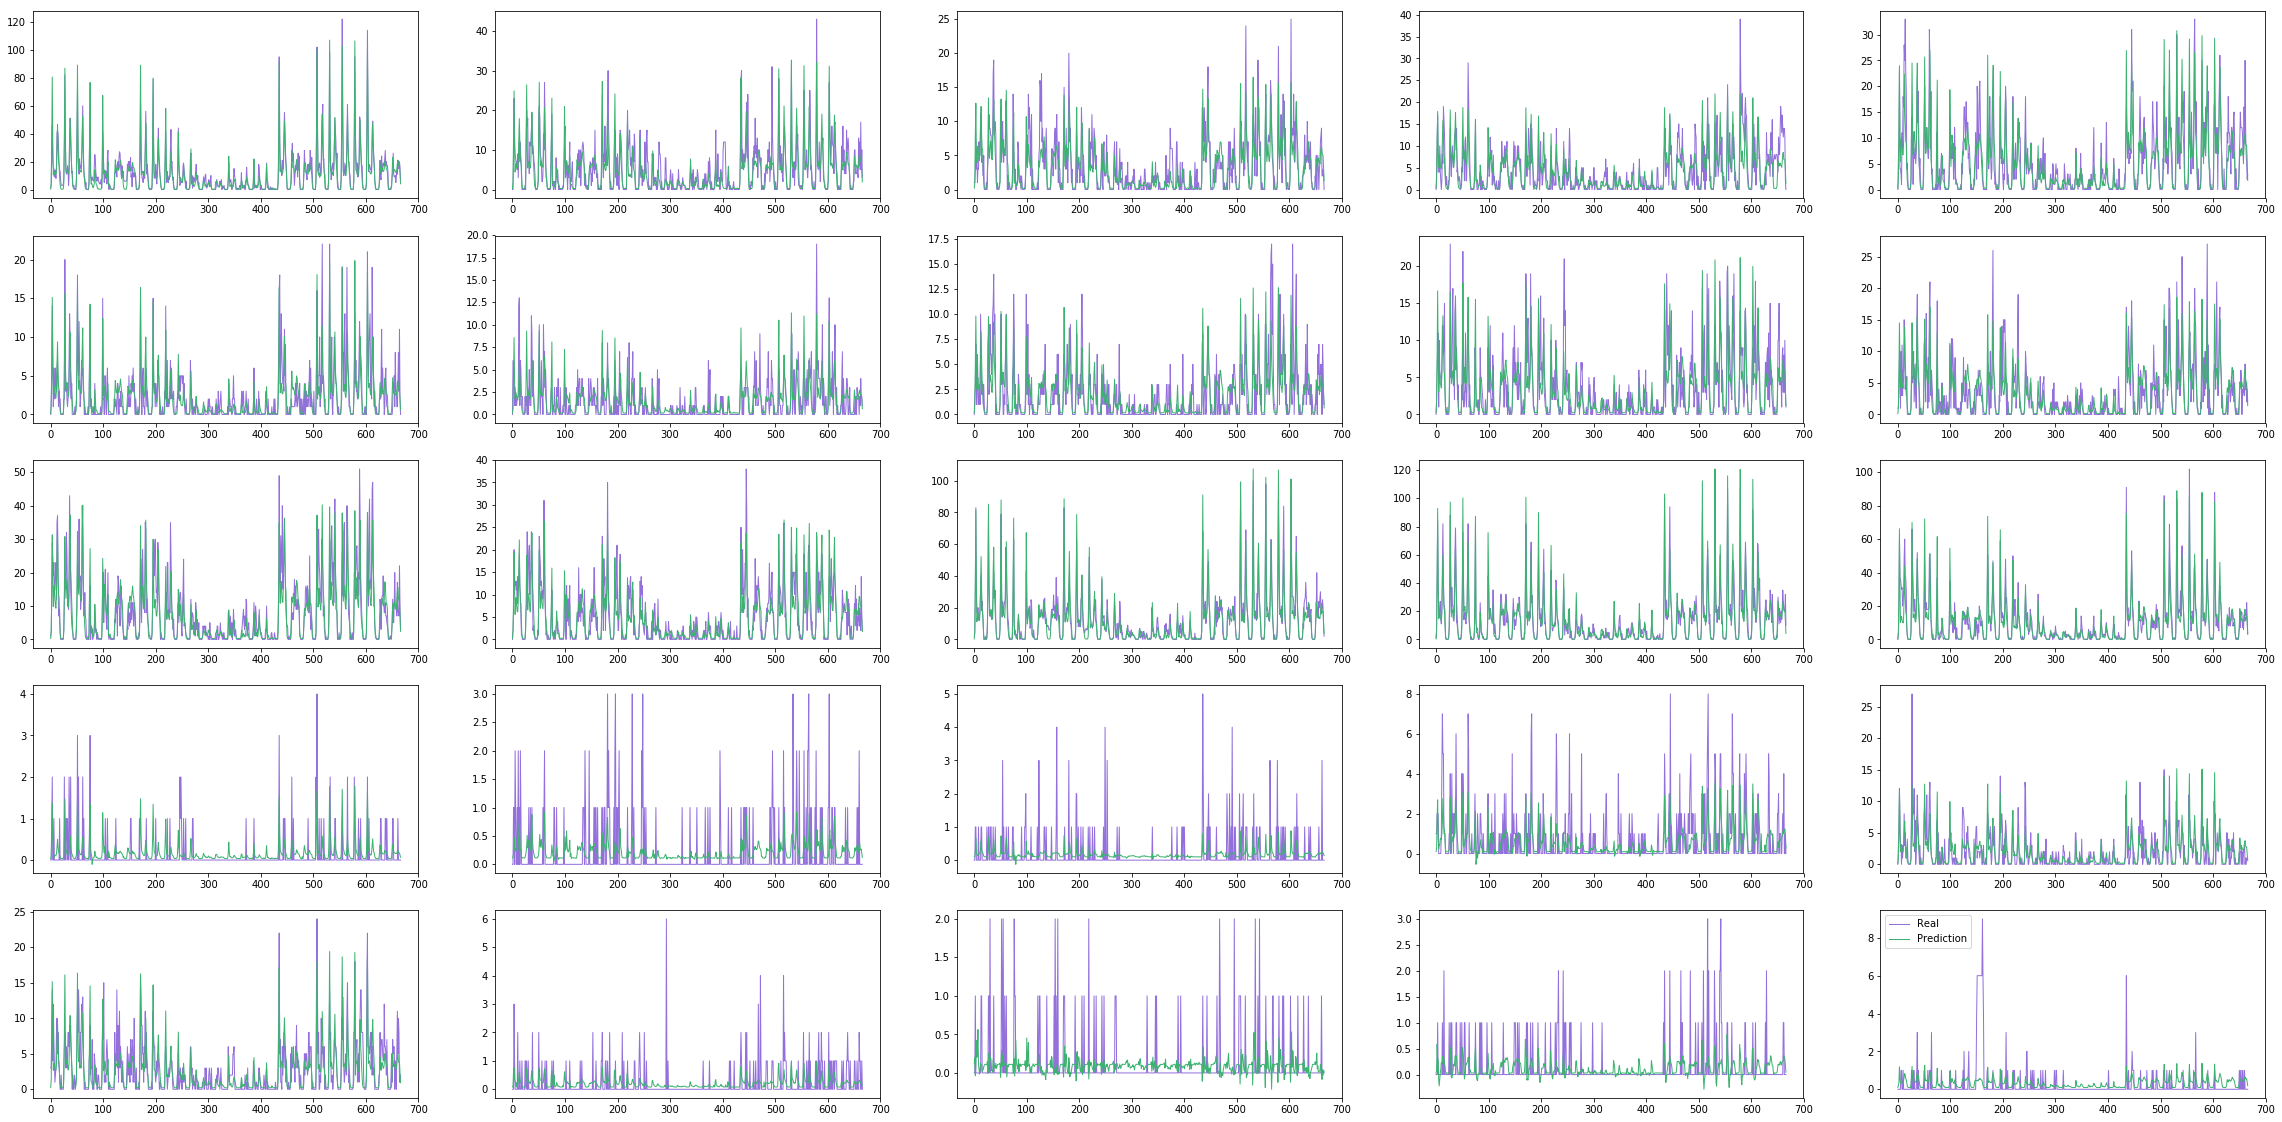

In [13]:
drawPredEveryLoc(preds, y_target,123)

RMSE:  3.14128


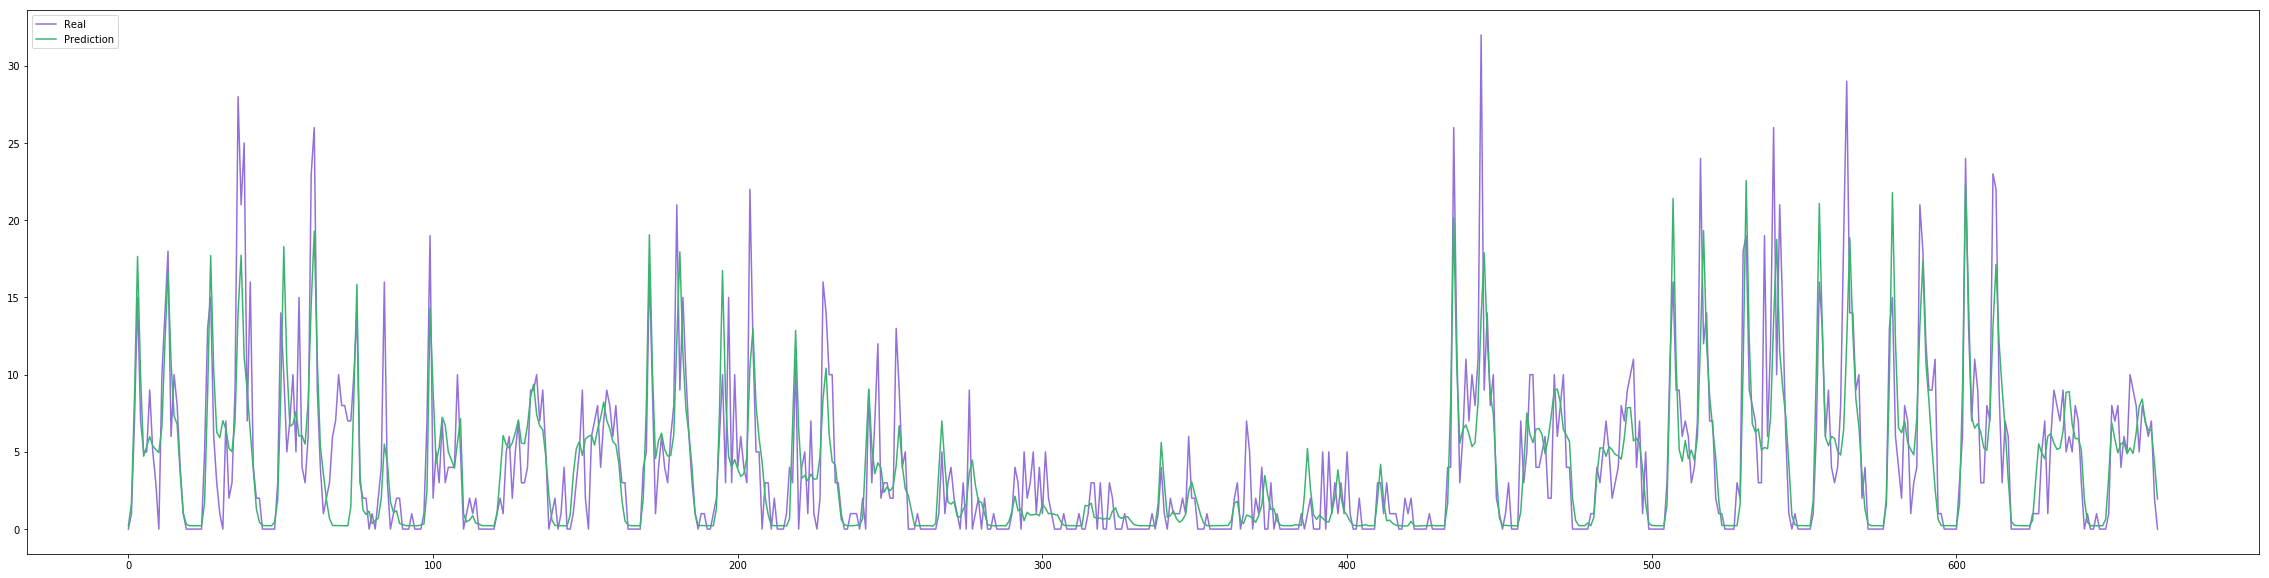

In [15]:
# 666 123
drawPredOneLoc(preds, y_target, 666)

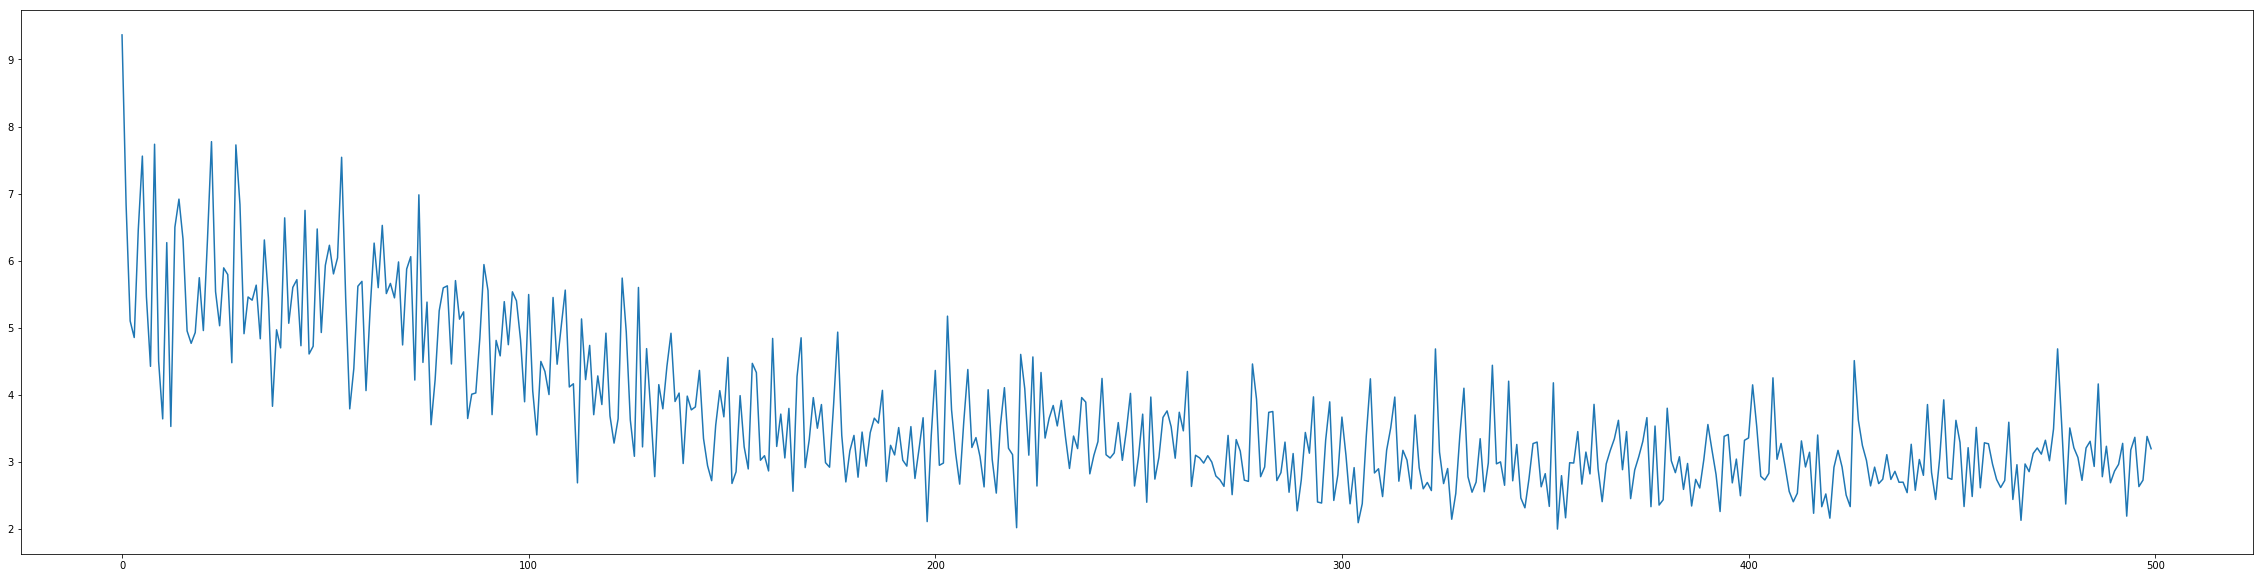

In [69]:
plt.figure(figsize=(40,10))
plt.plot(train_loss)
plt.show()
